<a href="https://colab.research.google.com/github/adrianrivadulla/FootNet_Development/blob/main/StepDetection_FinalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL TEST

The best model resulting from 5-fold cross-validation is updated and tested on the testing set.

The notebook requires DataFolds.npy and TestFolds.npy to exist in StepDetectionStudy > Data directory. DataFolds.npy and TestingSet.npy were generated using the notebook called TrainTest_Split.npy.

DataFolds contains five folds of participants that were used for 5-fold crossvalidation and TestingSet contains the participants that have been put aside for final testing and that have not taken part in any training step. This notebook concatenates the five folds in DataFolds and uses these data to update the best candidate model attained during 5-fold crossvalidation. Model parameters are updated for 5 epochs with no validation set. The updated model is then tested on the TestingSet.

**Make sure you're running on GPU before starting the notebook** for faster performance.



# Presettings

## Mount drive

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Make imports

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle
import scipy.io

## Directories

In [15]:
datadir = '/content/drive/My Drive/StepDetectionStudy/Data'
testdir = '/content/drive/My Drive/StepDetectionStudy/FinalTest'
finalmodeldir = '/content/drive/My Drive/StepDetectionStudy/FinalModel'

# Helper functions

## FlattenDataset

Flattens an structed list containing participants in the first sublevel (DatasetList[0]) and trials in the following sublevel (DatasetList[0][0])

In [16]:
def FlattenDataset(DatasetList):
    FlatList = []
    for participant in DatasetList:
        for trial in participant:
                FlatList = FlatList + trial
                
    return FlatList

## StandardiseData

Transforms X_train and X_val to z-scores using the mean and standard deviation of each variable in the training set X_train.

In [17]:
def StandardiseData(X_train, X_val):
    
    # calculate standardising parameters
    zero_mean = np.mean(np.hstack(X_train), axis=(0,1)) # mean of each variable
    one_std = np.std(np.hstack(X_train), axis=(0,1)) # std of each variable

    # standardise data
    for i in range(len(X_train)):
        for idim in range(len(zero_mean)):
            X_train[i][:,:,idim] = (X_train[i][:,:,idim] - zero_mean[idim])/ one_std[idim]

    for i in range(len(X_val)):
        for idim in range(len(zero_mean)):
            X_val[i][:,:,idim] = (X_val[i][:,:,idim] - zero_mean[idim])/ one_std[idim]
        
    return X_train, X_val, zero_mean, one_std

## ListToPaddedArray

Zero-pads MatList to arrays of maxlen. The padding is added at the beginning.

In [18]:
def ListToPaddedArray(MatList, maxlen):
    
    padded =np.empty((0,maxlen,MatList[0].shape[2]))
    
    for i in MatList:
        ipad = np.pad(i,((0,0),(maxlen-i.shape[1], 0),(0,0)),'constant')
        padded = np.vstack((padded, ipad))
            
    return padded

## GetStepEvents

Finds the first (foot-strike, fs) and last (toe-off, to) value in Labels that are > 0.51 i.e. contact. Labels is a list containing n strides.

In [19]:
def GetStepEvents(Labels):
    
    fs = []
    to = []    
    
    for stride in Labels:
      if len(stride.shape) == 2:
        on = np.where(stride[:,0] >= 0.50)[0][0]
        off = np.where(stride[on:,0] < 0.50)[0][0] + on
        
      elif len(stride.shape) == 3:
        on = np.where(stride[0,:,0] >= 0.50)[0][0]
        off = np.where(stride[0,on:,0] < 0.50)[0][0] + on
        
      fs.append(on)
      to.append(off)

    return fs, to

## PerformanceAssessment

Compares the original labels (Y_labels) against the predicted ones (Y_hat). Foot-strike and toe-off are detected in both real and predicted labels using the GetStepEvents funciton and then the difference (in ms) is calculated. Error metrics including precision, RMSE, parametric Bland-Altman 95% limits of agreement, 99 percentile and max error are calculated. Bland-Altman plots are saved to savingdir including the fold code valfold in the name so they can be identified.

In [20]:
def PerformanceAssessment(Y_labels, Y_hat, metadata, savingdir, valfold):

  # get gold standard contact events
  fs, to = GetStepEvents(Y_labels)    

  # get predicted contact events
  fs_hat,to_hat = GetStepEvents(Y_hat)

  # everything to milliseconds
  lastBra = [i for i, trialname in enumerate(metadata) if 'RBDS' in trialname][-1]

  fs_ms = np.zeros_like(fs, dtype=float)
  to_ms = np.zeros_like(to, dtype=float)

  fs_hat_ms = np.zeros_like(fs_hat, dtype=float)
  to_hat_ms = np.zeros_like(to_hat, dtype=float)

  for i in range(len(fs)):
    if i <= lastBra:
      fs_ms[i] = fs[i]*1/150
      to_ms[i] = to[i]*1/150
      fs_hat_ms[i] = fs_hat[i]*1/150
      to_hat_ms[i] = to_hat[i]*1/150

    else:
      fs_ms[i] = fs[i]*1/200
      to_ms[i] = to[i]*1/200
      fs_hat_ms[i] = fs_hat[i]*1/200
      to_hat_ms[i] = to_hat[i]*1/200

  # calculate errors
  ct_ms = to_ms - fs_ms
  ct_hat_ms = to_hat_ms - fs_hat_ms

  FSError = fs_ms - fs_hat_ms
  TOError = to_ms - to_hat_ms
  CTError = ct_ms - ct_hat_ms

  ## Error metrics

  # Precision
  fs_prec = np.count_nonzero(FSError == 0)/len(FSError)*100
  to_prec = np.count_nonzero(TOError == 0)/len(TOError)*100
  ct_prec = np.count_nonzero(CTError == 0)/len(CTError)*100

  # RMSE
  rmse_fs = np.sqrt(np.mean(FSError**2))
  rmse_to = np.sqrt(np.mean(TOError**2))
  rmse_ct = np.sqrt(np.mean(CTError**2))

  # Bland-Altman plots
  plt.figure()
  fs95top, fs95bottom = BlandAltmanPlot(fs_ms, fs_hat_ms, to_ms - fs_ms, valfold,'Contact_time (ms)','Error (ms)')
  plt.savefig(savingdir + '/FSBAplot_' + valfold + '.jpg')

  plt.figure()
  to95top, to95bottom = BlandAltmanPlot(to_ms, to_hat_ms, to_ms - fs_ms, valfold,'Contact_time (ms)','Error (ms)')
  plt.savefig(savingdir + '/TOBAplot_' + valfold + '.jpg')

  plt.figure()
  ct95top, ct95bottom = BlandAltmanPlot(ct_ms, ct_hat_ms, to_ms - fs_ms, valfold,'Contact_time (ms)','Error (ms)')
  plt.savefig(savingdir + '/CTBAplot_' + valfold + '.jpg')

  # 99 pctile
  fs_99 = np.percentile(np.abs(FSError),99)
  to_99 = np.percentile(np.abs(TOError),99)
  ct_99 = np.percentile(np.abs(CTError),99)

  # max error
  max_fs_error = max(np.abs(FSError))
  max_to_error = max(np.abs(TOError))
  max_ct_error = max(np.abs(CTError))

  # write it all out as a dictionary
  summary = {"precision" : [fs_prec, to_prec, ct_prec],
             "rmse" : [rmse_fs, rmse_to, rmse_ct],
             "95la" : [[fs95top, fs95bottom], [to95top, to95bottom], [ct95top, ct95bottom]],
             "pctile_99" : [fs_99, to_99, ct_99],
             "max_error" : [max_fs_error, max_to_error, max_ct_error]}

  return summary, fs_ms, fs_hat_ms, to_ms, to_hat_ms

## BlandAltmanPlot


Displays a Bland-Altman plot where the disagreement between two instruments (y-axis) is plotted against a variable t (time in this case for visualisation purposes, x-axis). The 95% limits of agreeement are calculated parametrically i.e. mean disagreement +- 1.96*sd disagreement) and returned as input. The figure includes the 0 line disagreement line, mean disasgreement line, upper and lower 95% limits of agreement and regression line between disagreement and variable t.

In [21]:
def BlandAltmanPlot(data1, data2, t, PlotTitle, XLabel, YLabel, *args, **kwargs):

    data1     = np.asarray(data1)               # instrument 1
    data2     = np.asarray(data2)               # instrument 2
    mean      = np.mean([data1, data2], axis=0) # mean of instrument 1 and 2
    diff      = data1 - data2                   # Difference between data1 and data2
    bias      = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    toplim    = bias + 1.96*sd
    bottomlim = bias - 1.96*sd
    line      = np.polyfit(t, diff, 1)

    plt.scatter(t, diff, *args, **kwargs)
    plt.axhline(bias, color='red', linestyle='-')
    plt.axhline(0, color='black', linestyle='-')
    plt.axhline(toplim, color='black', linestyle='-')
    plt.axhline(bottomlim, color='black', linestyle='-')

    axes = plt.gca()
    x = np.array(axes.get_xlim())
    y = line[0] * x + line[1]
    plt.plot(x, y, '--')
    plt.axhspan(bias - 1.96*sd, bias + 1.96*sd , alpha=0.5, color='grey')

    plt.title(PlotTitle)
    plt.xlabel(XLabel)
    plt.ylabel(YLabel)
 
    return toplim, bottomlim

# Main 

## Load data

In [22]:
trainfolds = np.load(datadir + '/DataFolds.npy', allow_pickle=True)
trainfolds = trainfolds.item()
trainset = {}
for key in list(trainfolds['Fold_0'].keys()):
  trainset[key] = []
  for fold in list(trainfolds.keys()):
    trainset[key] = trainset[key] + trainfolds[fold][key] 

testset = np.load(datadir + '/TestingSet.npy', allow_pickle=True)
testset = testset.item()

## Preprocessing

In [23]:
# Flatten data
for key in list(trainset.keys()):
  trainset[key] = FlattenDataset(trainset[key])
  testset[key] = FlattenDataset(testset[key])

## Standardise data
trainset['X'], testset['X'], zero_mean, one_std = StandardiseData(trainset['X'], testset['X'])

## Padd data
X_train = ListToPaddedArray(trainset['X'], 200)
Y_train = ListToPaddedArray(trainset['Y'], 200)
X_test = ListToPaddedArray(testset['X'], 200)
Y_test = ListToPaddedArray(testset['Y'], 200)

## Model updating

Epoch 1/5
125/125 [==============================] - 339s 3s/step - loss: 0.0166 - binary_accuracy: 0.9898
Epoch 2/5
125/125 [==============================] - 328s 3s/step - loss: 0.0125 - binary_accuracy: 0.9919
Epoch 3/5
125/125 [==============================] - 328s 3s/step - loss: 0.0120 - binary_accuracy: 0.9923
Epoch 4/5
125/125 [==============================] - 325s 3s/step - loss: 0.0116 - binary_accuracy: 0.9925
Epoch 5/5
125/125 [==============================] - 321s 3s/step - loss: 0.0112 - binary_accuracy: 0.9928


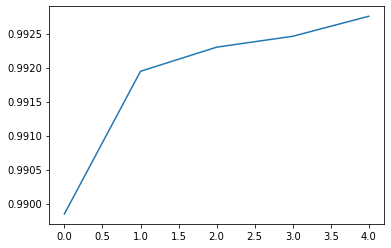

In [24]:
# Load model
FootNet = keras.models.load_model(testdir + '/FootNet_best_candidate')

# Update model weigths for 5 epochs
history = FootNet.fit(X_train, Y_train, batch_size=200, epochs=5)
plt.figure()
plt.plot(history.history['binary_accuracy'])

# add standardisation parameters to model
FootNet._zero_mean = tf.Variable(zero_mean, trainable=False)
FootNet._one_std = tf.Variable(one_std, trainable=False)

# save model
FootNet.save(finalmodeldir +'/FootNetModel')

## Model assessment


Test accuracy: 0.9929304
({'precision': [44.111570247933884, 37.33930211202938, 23.97842056932966], 'rmse': [0.004641006071244823, 0.005737438202084836, 0.007742504134215225], '95la': [[0.009404667384133134, -0.008741597289244857], [0.01196327358747535, -0.01028589372827731], [0.01564987237826766, -0.014635562613957896]], 'pctile_99': [0.013333333333333308, 0.015000000000000013, 0.020000000000000018], 'max_error': [0.020000000000000018, 0.025000000000000022, 0.033333333333333326]}, array([0.90666667, 0.9       , 0.9       , ..., 0.635     , 0.635     ,
       0.635     ]), array([0.9       , 0.9       , 0.89333333, ..., 0.63      , 0.63      ,
       0.63      ]), array([1.15333333, 1.14666667, 1.14666667, ..., 0.82      , 0.82      ,
       0.82      ]), array([1.16 , 1.16 , 1.16 , ..., 0.82 , 0.82 , 0.815]))


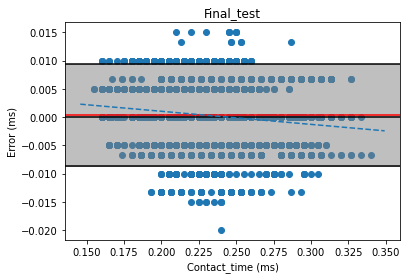

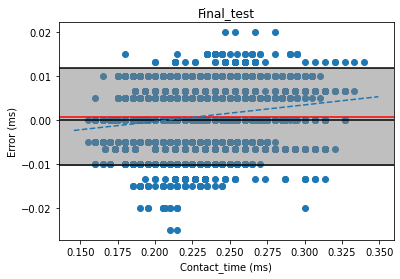

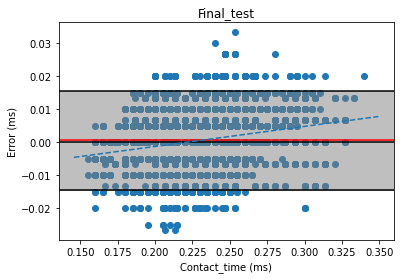

In [25]:
# Predict contact phases
y_hat = FootNet.predict(X_test)

# get rid of noise in predictions due to padding
for i, labelvector in enumerate(y_hat):
  padend = np.where(labelvector[:,0] < 0.1)[0][0]
  labelvector[:padend,0] = 0
  y_hat[i] = labelvector

# Calculate test accuracy
test_acc = tf.keras.metrics.BinaryAccuracy()
test_acc.update_state(Y_test, y_hat)
test_accuracy = test_acc.result().numpy()
print('Test accuracy: ' + str(test_accuracy))

# Performance assessment
summary = PerformanceAssessment(Y_test, y_hat, testset['meta'], testdir, 'Final_test') 
print(summary)

## Save performance metrics

In [26]:
#save history and performance summary in results dic
results = {}
results['summary'] = summary
results['history'] = history.history
with open(testdir +'/summary_'+ 'Final_test', 'wb') as f:
 pickle.dump(results, f)

# save for final analysis in Matlab (paper)
scipy.io.savemat(testdir + '/y_and_yhat.mat', dict(y=Y_test, yhat=y_hat, meta = testset['meta']))
